In [44]:
import numpy as np
import scipy.optimize as optimize
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

### Portfolio optimization with 6 stocks

In [6]:
stocks=['AAPL','WMT','TSLA','GE','AMZN','DB']
weights=np.array([[0.2,0.3,0.1,0.1,0.1,0.2]]).T # some weight of choice, initial weight
start_date='2016-01-01'
stop_date='2017-01-01'
period=252

In [7]:
print(weights.shape)
weights.T.shape

(6, 1)


(1, 6)

In [51]:
# since many portfolios are to be generated
# hence it is best to make functions over as many tasks as possible

def stock_data(stocks,start_data,stop_date): # get the closing price
    stock_data={}
    for stock in stocks:
        ticker=yf.Ticker(stock)
        stock_data[stock]=ticker.history(start=start_date,stop=stop_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(stock_data): # plot closing price
    stock_data.plot(figsize=(10,5))
    plt.show()
    
def log_return(stock_hist): # get log return
    log_ret=np.log(stock_hist/stock_hist.shift(1))
    return log_ret[1:]
    
def portfolio_ret(log_ret,w,period=1): # given log_ret of stocks and weights, find the portfolio_ret
    pr=np.dot(log_ret.mean(),w)*period
    p_volatility=np.sqrt(np.dot(w.T ,np.dot(( log_ret.cov()*period), w))) # portfolio_volatility
    #print('pr is',pr)
    #print('volatility is',p_volatility)
    return {'pr':pr,'pv':p_volatility,'sr':pr/p_volatility} # sr- sharpe ratio, taking risk free rate=0
    
def gen_n_portfolio(log_ret,period,n):
    wl=[]
    prl=[]
    pvl=[]
    for i in range(n):
        w=np.random.random(6).reshape(6,1) # generate 6 weights wrt 6 stocks
        w=w/w.sum()
        ps=portfolio_ret(log_ret,w,period)
        pr=ps['pr']
        pv=ps['pv']
        wl.append(w)
        prl.append(pr)
        pvl.append(pv)
    return wl,np.reshape(prl,(n,1)),np.reshape(pvl,(n,1))
        
        
def plot_portfolio(pv,pr): # use output from gen_n_portfolio
    plt.figure(figsize=(10,6))
    plt.scatter(pv,pr,c=pr/pv,marker='o') # c reps Sharpe ratio
    plt.grid(True)
    plt.xlabel('risk')
    plt.ylabel('return')
    plt.colorbar(label='Sharpe ratio')
    plt.show()
    
def neg_sharpe(w,mean,sigma,period): # return negative of Sharpe ratio
    # this basically acts as the function we give to 'optimizer' to minimize (hence negative).
    pr=np.dot(mean,w)*period
    p_volatility=np.sqrt(np.dot(w.T ,np.dot((sigma *period), w)))
    return -pr/p_volatility
    

def opt(log_ret,w_in,period):
    sigma=log_ret.cov()
    mean=log_ret.mean()
    print('Sharpe for initial weight:',neg_sharpe(w_in,mean,sigma,period))
    cons=({'type':'eq','fun':lambda x: np.sum(x)-1}) # constraints for optimizer is the function 'fun': sum of weights-1=0, type: equality
    #note: constraints take in type- 'eq' or 'ieq', then define the function as eqn with 0 on one side.
    bound=tuple((0,1) for _ in range(6)) # bounds- all 6 weights lie in range (0,1)
    print('opt',type(log_ret))
    optimum_w=optimize.minimize(fun=neg_sharpe,x0=w_in,args=(mean,sigma,period),method='SLSQP',\
                                constraints=cons,bounds=bound)
    return optimum_w
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    


In [37]:
stock_hist=stock_data(stocks,start_date,stop_date)
log_ret=log_return(stock_hist)

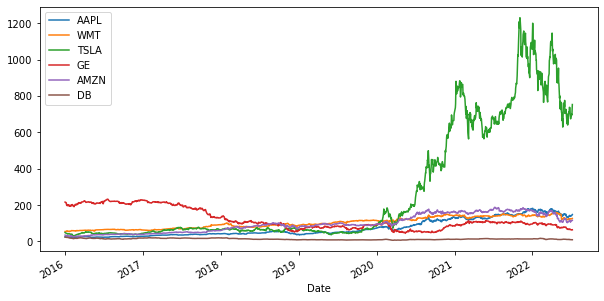

In [38]:
show_data(stock_hist)

In [39]:
portfolio_ret(log_ret,weights,period)

{'pr': array([0.10623526]),
 'pv': array([[0.2220889]]),
 'sr': array([[0.47834565]])}

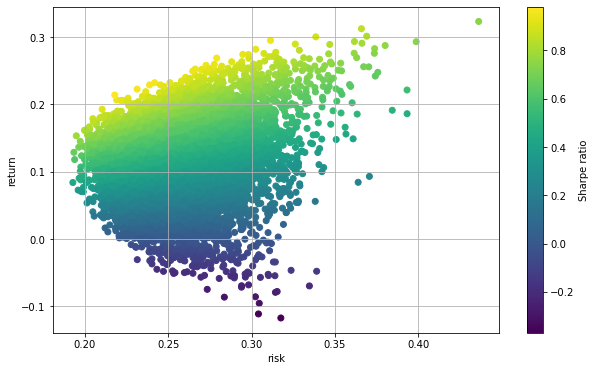

In [40]:
w,pr,pv=gen_n_portfolio(log_ret,period,10000)
plot_portfolio(pv,pr)


In [41]:
# sharpe ratio for some weight w[0] generated by gen_portfolio
print(portfolio_ret(log_ret,w[0].reshape(6,),period)['sr']) 

0.29787032633145355


In [42]:
w[0].reshape(6,)

array([0.17730442, 0.15895402, 0.08813006, 0.23394663, 0.17534735,
       0.16631752])

In [45]:
optimum=opt(log_ret,w[0].reshape(6,),period) 

Sharpe for initial weight: -0.29787032633145355
opt <class 'pandas.core.frame.DataFrame'>


In [46]:
type(optimum)
# ref here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html
# results in ['x']
# whether optimizer was successful in ['success']

scipy.optimize.optimize.OptimizeResult

In [52]:
print(optimum)

     fun: -1.0385447387766844
     jac: array([-7.33137131e-06,  9.28342342e-05, -1.86771154e-04,  1.36733952e+00,
        5.47558516e-02,  1.29753196e+00])
 message: 'Optimization terminated successfully'
    nfev: 71
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([4.99246009e-01, 3.47607024e-01, 1.53146967e-01, 2.71592644e-17,
       1.02457105e-17, 3.87060176e-17])


In [47]:
optimum['success']

True

In [48]:
optimum['x'] # the optimum weights

array([4.99246009e-01, 3.47607024e-01, 1.53146967e-01, 2.71592644e-17,
       1.02457105e-17, 3.87060176e-17])

In [49]:
def show_portfolio(optimum_w,log_ret,period,pv,pr):
    dictxy=portfolio_ret(log_ret,optimum_w,period)
    x1=dictxy['pv']
    y1=dictxy['pr']
    plt.figure(figsize=(10,6))
    plt.scatter(pv,pr,c=pr/pv,marker='o')
    plt.grid(True)
    plt.xlabel('risk')
    plt.ylabel('return')
    plt.colorbar(label='Sharpe ratio')
    plt.plot(x1,y1,'r*',markersize=20)
    plt.show()

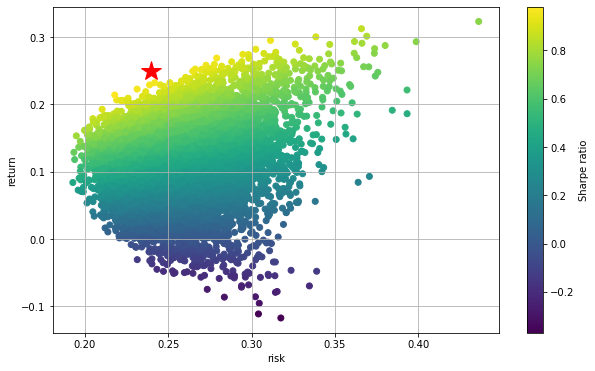

In [50]:
show_portfolio(optimum['x'],log_ret,period,pv,pr)